# 因果効果推定手法の実装

LaLonde データセットを用いて、因果効果推定の主要な手法を実装・比較する。
- 回帰ベース（OLS）
- 傾向スコアマッチング（PSM）
- 逆確率重み付け（IPW）
- Doubly Robust 推定量

## 分析の構成

1. **真の因果効果（ベンチマーク）**: 実験データ（sample=1, RCT）から計算
2. **観察データでの推定**: treated=1（sample=1）とCPS対照群（sample=2, treated=0）を組み合わせた選択バイアスのあるデータで推定
3. **手法の比較**: 各手法が真の因果効果にどの程度近づけるかを評価

## LaLonde データセットについて

このデータセットは、National Supported Work (NSW) プログラムの効果を分析するために使用されます。

### 変数の定義

- **treated**: 処置変数（1 = 職業訓練プログラムに参加、0 = 非参加）
- **age**: 年齢（歳）
- **educ**: 教育年数（年）
- **black**: 人種ダミー（1 = 黒人、0 = その他）
- **hispan**: ヒスパニック系ダミー（1 = ヒスパニック、0 = その他）
- **married**: 結婚状況（1 = 既婚、0 = 未婚）
- **nodegree**: 学位なしダミー（1 = 高卒資格なし、0 = あり）
- **re74**: 1974年の実質所得（ドル）
- **re75**: 1975年の実質所得（ドル）
- **re78**: 1978年の実質所得（ドル）- アウトカム変数
- **early_ra**: Smith and Todd (2005) の早期ランダム割り当てサンプルへの包含を示す指標変数（実験サンプルに含まれない場合は欠損値）
- **sample**: サンプルの種類（1 = NSW実験サンプル、2 = CPS比較グループ、3 = PSID比較グループ）
- **experimental**: 実験サンプルに含まれるかどうか（1 = 実験サンプル、0 = それ以外）

### サンプルグループの説明

**1. NSW実験サンプル (sample=1)**
- National Supported Work (NSW) プログラムのランダム化比較試験（RCT）データ
- 処置群と対照群がランダムに割り当てられているため、因果効果の推定が容易
- 真の因果効果のベンチマークとして使用される

**2. CPS比較グループ (sample=2)**
- Current Population Survey（米国の雇用統計調査）から抽出された非実験的な対照群
- NSW処置群と比較するために構築された観察データ
- ランダム割り当てではないため、選択バイアスが存在する可能性

**3. PSID比較グループ (sample=3)**
- Panel Study of Income Dynamics（所得動態パネル調査）から抽出された非実験的な対照群
- CPSと同様に、観察データとしてNSW処置群との比較に使用
- より長期的な所得履歴データを含む

LaLonde (1986) とその後の研究では、実験データ（NSW）で得られた因果効果と、観察データ（CPSやPSID）を用いた非実験的手法で得られた推定値を比較することで、各種因果推論手法の妥当性を検証しています。


## 1. データの読み込みと前処理


In [292]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from causallib.estimation import IPW, PropensityMatching, StratifiedStandardization, AIPW, WeightedStandardization
from causallib.evaluation import evaluate
import statsmodels.api as sm
from statsmodels.genmod import families
import rdrobust
import rddensity

import warnings
warnings.filterwarnings('ignore')

In [41]:
# Load LaLonde dataset
df_org = pd.read_csv('data/input/ec675_nsw.tab', sep='\t')

print(f"Shape: {df_org.shape}")
print(f"\nColumns: {df_org.columns.tolist()}")
print(f"\nSample distribution:")
print(df_org['sample'].value_counts().sort_index())

Shape: (19204, 13)

Columns: ['treated', 'age', 'educ', 'black', 'married', 'nodegree', 'dwincl', 're74', 're75', 're78', 'hisp', 'early_ra', 'sample']

Sample distribution:
sample
1.0      722
2.0    15992
3.0     2490
Name: count, dtype: int64


In [43]:
df_org.isna().sum()

treated     18482
age             0
educ            0
black           0
married         0
nodegree        0
dwincl      18482
re74            0
re75            0
re78            0
hisp            0
early_ra    18482
sample          0
dtype: int64

# 関数定義

In [297]:
def plot_distribution(df, X_cols, t_col):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))
    axs = axs.flatten()
    for i, col in enumerate(X_cols):
        ax = axs[i]
        sns.histplot(data=df, x=col, hue=t_col, stat='density', common_norm=False, ax=ax, alpha=0.5)
        # 点で平均を表示
        ax.scatter(df.loc[df[t_col] == 1, col].mean(), 0, alpha=0.5, color='orange', s=100, zorder=5, label='Treated Mean')
        ax.scatter(df.loc[df[t_col] == 0, col].mean(), 0, alpha=0.5, color='blue', s=100, zorder=5, label='Treated Mean')
    plt.tight_layout()

# RCTの介入群の対照群による効果の推定

実験データ（sample=1）のみを使用して、RCTによる真の因果効果（True ATE）を計算します。
これがベンチマークとなります。

In [ ]:
y_col = 're78'
t_col = 'treated'
X_cols = ['age', 'educ', 'black', 'married', 'nodegree', 're74', 're75', 'hisp']

In [197]:
# 実験データのみ対象にする
df_exp = df_org[df_org['sample'] == 1].copy()#.query('black==1 and married==1 and nodegree==1')

In [198]:
len(df_exp)

722

In [201]:
(df_exp['re78']==0).mean()

np.float64(0.27146814404432135)

## 可視化

0の割合: 27.15%


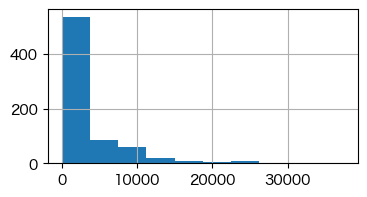

In [449]:
plt.figure(figsize=(4,2))
df_exp['re75'].hist()
print(f'0の割合: {(df_exp["re78"]==0).mean():.2%}')

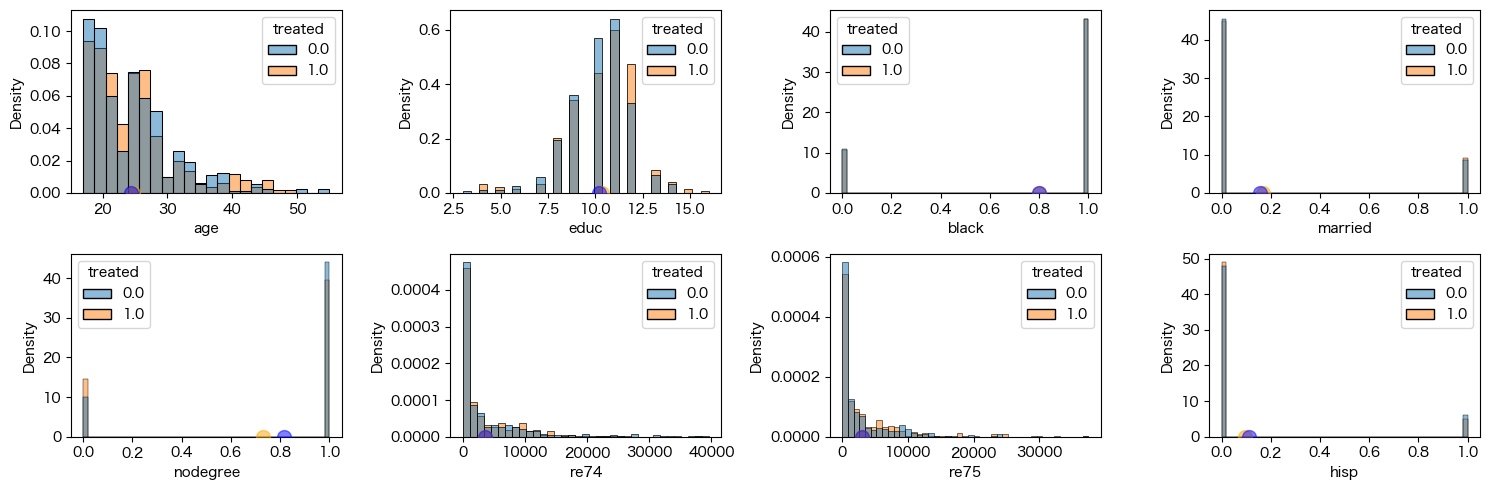

In [444]:
plot_distribution(df_exp, X_cols, t_col)

## 単純比較
- 分布をみたところ、介入有無で共変量の分布がほとんど変わらなさそうなので、独立性条件${Y(1), Y(0)}\perp T$が成り立っていると仮定できそう
- 厳密には、共変量同士の同時分布は見ていないので同じかはわからない
```math
E[Y|T=1] - E[Y|T=0] = \frac{1}{N_1} \sum_{i:T_i=1} Y_i - \frac{1}{N_0} \sum_{i:T_i=0} Y_i
```

In [299]:
# Extract experimental data (sample=1) for TRUE ATE calculation

# df_exp = df_exp.dropna(subset=['treated', 're78'])

treatment_exp = df_exp['treated'].values
outcome_exp = df_exp['re78'].values

# TRUE ATE from RCT
true_ate = outcome_exp[treatment_exp == 1].mean() - outcome_exp[treatment_exp == 0].mean()

print("=" * 60)
print(f"Treatment group (n={int((treatment_exp == 1).sum())}): Mean outcome = {outcome_exp[treatment_exp == 1].mean():.2f}")
print(f"Control group (n={int((treatment_exp == 0).sum())}): Mean outcome = {outcome_exp[treatment_exp == 0].mean():.2f}")
print(f"ATE = {true_ate:.2f}")
print("=" * 60)

Treatment group (n=297): Mean outcome = 5976.35
Control group (n=425): Mean outcome = 5090.05
ATE = 886.30


## 回帰分析

In [302]:
y = df_exp[y_col]
X = df_exp[[t_col]+X_cols]
# 定数の追加
X = sm.add_constant(X)

In [303]:
sm_model = sm.OLS(y, X)
sm_results = sm_model.fit()

ate_ols = sm_results.params[t_col]
print(sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.689
Date:                Tue, 30 Dec 2025   Prob (F-statistic):           0.000156
Time:                        00:51:59   Log-Likelihood:                -7318.4
No. Observations:                 722   AIC:                         1.466e+04
Df Residuals:                     712   BIC:                         1.470e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3628.5347   2611.913      1.389      0.1

## 一般化線形モデル
- 確率分布：Tweedie分布
- リンク関数：対数リンク関数

In [419]:
def fit_tweedie_glm(df, y_col, X_cols, t_col):
    y = df[y_col]
    X = df[[t_col]+X_cols]
    X = sm.add_constant(X)
    family = families.Tweedie(
        link=families.links.Log()
    )
    tweedie_glm = sm.GLM(y, X, family=family)
    tweedie_results = tweedie_glm.fit()
    print(tweedie_results.summary())
    return tweedie_results

In [420]:
tweedie_results = fit_tweedie_glm(df_exp, y_col, X_cols, t_col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   re78   No. Observations:                  722
Model:                            GLM   Df Residuals:                      712
Model Family:                 Tweedie   Df Model:                            9
Link Function:                    Log   Scale:                          6935.8
Method:                          IRLS   Log-Likelihood:                -334.95
Date:                Tue, 30 Dec 2025   Deviance:                   4.6408e+06
Time:                        01:24:03   Pearson chi2:                 4.94e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04124
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1877      0.486     16.837      0.0

In [341]:
tweedie_results.aic

np.float64(7606.538836154528)

In [454]:
effect_treated = np.exp(tweedie_results.params[t_col])
# 対数リンク関数を用いた場合の回帰係数は、介入群の期待値が対照群の期待値の何倍になるかを示しているため、それをもとに絶対値として想定される効果を算出する
att_glm = (1 - 1 / effect_treated) * df_exp.loc[df_exp['treated'] == 1, y_col].mean()
# ate_glm = (effect_treated - 1) * df_exp.loc[df_exp['treated'] == 0, y_col].mean() # 対照群における効果の場合
print(att_glm)

838.655962492586


In [468]:
df_exp['re78'].describe()

count      722.000000
mean      5454.635786
std       6252.943352
min          0.000000
25%          0.000000
50%       3951.889000
75%       8772.004000
max      60307.930000
Name: re78, dtype: float64

## まとめ
- 3つの手法によって得られた効果推定値を比較

In [466]:
df_result_exp = pd.DataFrame({
    'method': ['Simple Comparison', 'OLS Regression',  'GLM (Tweedie)'],
    'type': ['ATE, abs', 'ATE, abs', 'ATE, ratio'],
    'effect': [true_ate, ate_ols,  effect_treated]
})

In [467]:
df_result_exp#.to_clipboard()

,method,type,effect
0,Simple Comparison,"ATE, abs",886.303822
1,OLS Regression,"ATE, abs",824.623711
2,GLM (Tweedie),"ATE, ratio",1.163236


# 介入群と非実験群による効果の推定

- **処置群**: sample=1 かつ treated=1（実験の処置群）
- **対照群**: sample=2 かつ treated=0（CPS比較グループ）

この組み合わせにより、選択バイアスが存在する観察データを構築します。

In [345]:
df_treated = df_org[(df_org['sample'] == 1) & (df_org['treated'] == 1)].copy()
df_control = df_org[(df_org['sample'] == 2)].copy().fillna({'treated': 0})

df_obs = pd.concat([df_treated, df_control], ignore_index=True)#.query('black==1 and married==1 and nodegree==1')

print(f"Treated group (sample=1, treated=1): n={len(df_treated)}")
print(f"Control group (sample=2, treated=0): n={len(df_control)}")
print(f"Total observational sample: n={len(df_obs)}")

Treated group (sample=1, treated=1): n=297
Control group (sample=2, treated=0): n=15992
Total observational sample: n=16289


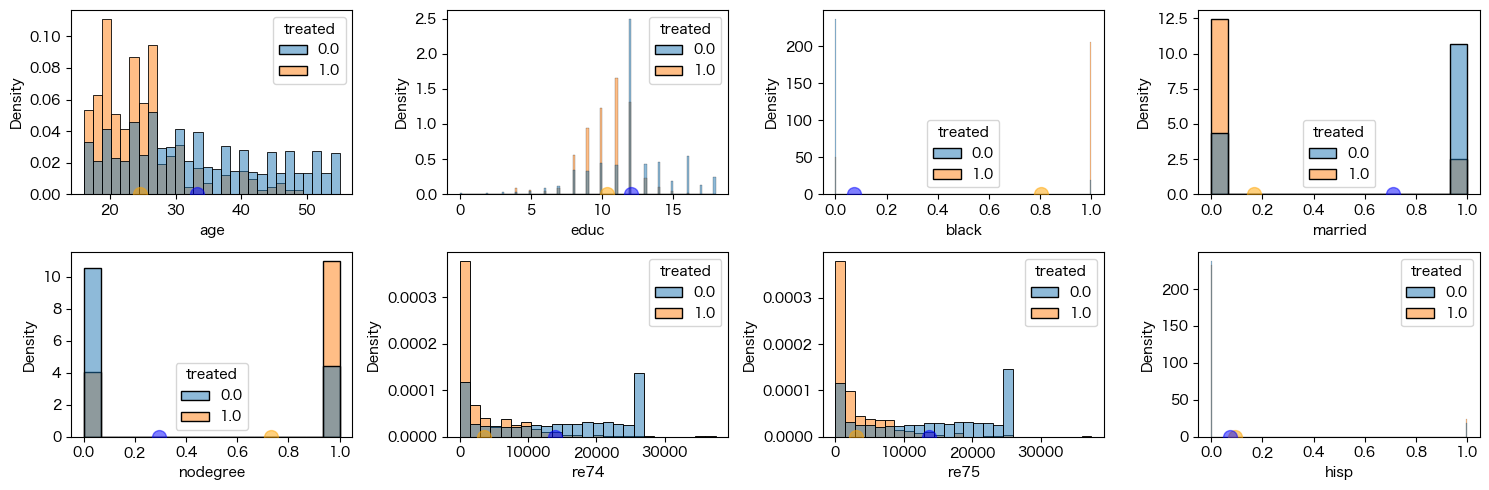

In [346]:
plot_distribution(df_obs, X_cols, t_col)

## 一般化線形モデル

In [422]:
y = df_obs[y_col]
X = df_obs[[t_col]+X_cols]
t = df_obs[t_col]

In [421]:
tweedie_results_obs = fit_tweedie_glm(df_obs, y_col, X_cols, t_col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   re78   No. Observations:                16289
Model:                            GLM   Df Residuals:                    16279
Model Family:                 Tweedie   Df Model:                            9
Link Function:                    Log   Scale:                          4381.8
Method:                          IRLS   Log-Likelihood:                -10262.
Date:                Tue, 30 Dec 2025   Deviance:                   8.9773e+07
Time:                        01:24:17   Pearson chi2:                 7.13e+07
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5179
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9188      0.035    253.470      0.0

In [354]:
effect_treated_obs = np.exp(tweedie_results_obs.params[t_col])
effect_treated_obs

np.float64(0.7548766370484118)

## 傾向スコアを用いた手法1: マッチング


In [355]:
# Estimate propensity scores
ps_model = LogisticRegression(max_iter=1000, random_state=42, C=0.001, class_weight='balanced', solver='liblinear')
ps_model.fit(X, t)
t_pred = ps_model.predict_proba(X)
roc_auc_linear = roc_auc_score(t, t_pred[:,1])
propensity_scores = ps_model.predict_proba(X)[:, 1]

print(f"ROC AUC of Propensity Score Model: {roc_auc_linear:.4f}")
print(f"Propensity score range: [{propensity_scores.min():.4f}, {propensity_scores.max():.4f}]")
print(f"Treated group - mean PS: {propensity_scores[t == 1].mean():.4f}")
print(f"Control group - mean PS: {propensity_scores[t == 0].mean():.4f}")

ROC AUC of Propensity Score Model: 0.9943
Propensity score range: [0.0182, 0.9189]
Treated group - mean PS: 0.8172
Control group - mean PS: 0.1673


In [356]:
propensity_scores[t == 0].max()

np.float64(0.7248288738046011)

Text(0.5, 1.0, 'Propensity Score Distribution by Treatment Group')

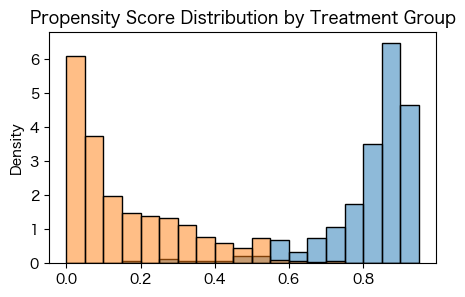

In [357]:
plot_kwargs = {
    'stat': 'density',
    'bins': np.arange(0, 1, 0.05),
    'alpha': 0.5,
}
# 傾向スコアの分布を可視化
plt.figure(figsize=(5, 3))
sns.histplot(propensity_scores[t == 1], label='Treated', **plot_kwargs)
sns.histplot(propensity_scores[t == 0], label='Control',  **plot_kwargs)
plt.title('Propensity Score Distribution by Treatment Group')

## 傾向スコアマッチング


In [358]:
pm = PropensityMatching(learner=ps_model, n_neighbors=1)
pm.fit(df_obs[X_cols], df_obs[t_col], df_obs[y_col])

,learner,LogisticRegre...r='liblinear')
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.001
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well

In [376]:
outcomes = pm.estimate_population_outcome(df_obs[X_cols], df_obs[t_col])
effect_pm = pm.estimate_effect(outcomes[1], outcomes[0])

In [377]:
effect_pm

diff   -9599.302911
dtype: float64

## 逆確率重み付け（IPW）


In [378]:
ipw = IPW(learner=ps_model, clip_min=0.05, clip_max=0.95)
ipw.fit(df_obs[X_cols], df_obs[t_col], df_obs[y_col])

outcomes = ipw.estimate_population_outcome(df_obs[X_cols], df_obs[t_col], df_obs[y_col])
effect_ipw = ipw.estimate_effect(outcomes[1], outcomes[0])
effect_ipw

diff   -6419.612595
dtype: float64

<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

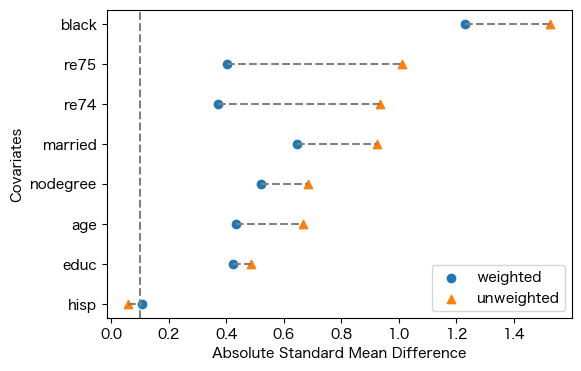

In [365]:
results = evaluate(ipw, df_obs[X_cols], df_obs[t_col], df_obs[y_col])
fig, ax = plt.subplots(figsize=(6, 4))
results.plot_covariate_balance(kind='love', ax=ax, thresh=0.1)

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

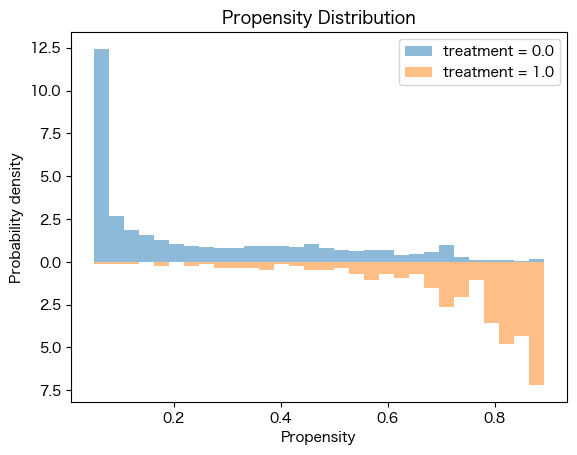

In [366]:
results.plot_weight_distribution()

## Doubly Robust 推定量

In [367]:
ipw = IPW(LogisticRegression(max_iter=1000, random_state=42, C=0.001, class_weight='balanced', solver='liblinear'), clip_min=0.05, clip_max=0.95)
std = StratifiedStandardization(learner=LinearRegression())
dr = AIPW(std, ipw)
dr.fit(df_obs[X_cols], df_obs[t_col], df_obs[y_col])

,outcome_model,StratifiedSta...rRegression())
,weight_model,IPW(_doc_link...='liblinear'))
,outcome_covariates,None
,weight_covariates,None
,overlap_weighting,False
,learner,"{np.float64(0.0): LinearRegression(), np.float64(1.0): LinearRegression()}"
,treatment_values,None
,predict_proba,False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.001
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0


In [368]:
pop_outcome = dr.estimate_population_outcome(df_obs[X_cols], df_obs[t_col], df_obs[y_col])
effect = dr.estimate_effect(pop_outcome[1], pop_outcome[0])
pop_outcome, effect

(treated
 0.0    14674.881397
 1.0     8732.411116
 dtype: float64,
 diff   -5942.470281
 dtype: float64)

## 差分の差分
- re75を施策実施前、re78を施策実施後のアウトカムとして利用
- postかどうかのダミー変数を作成し、処置群との交互作用項を導入することで、差分の差分推定量を計算する。
- statsmodelsのGLMで実装する（上記と同じ形式で）

In [369]:
# データの縦持ち変換: re75 (pre) と re78 (post) を1つのカラムに
df_pre = df_obs.copy()
df_pre['outcome'] = df_pre['re75']
df_pre['post'] = 0

df_post = df_obs.copy()
df_post['outcome'] = df_post['re78']
df_post['post'] = 1

df_did = pd.concat([df_pre, df_post], ignore_index=True)

print(f"DiD用データセット: {df_did.shape}")
print(f"  Pre期間 (post=0): {(df_did['post']==0).sum()}行")
print(f"  Post期間 (post=1): {(df_did['post']==1).sum()}行")

DiD用データセット: (32578, 15)
  Pre期間 (post=0): 16289行
  Post期間 (post=1): 16289行


In [370]:
# 交互作用項の作成
df_did['treated_x_post'] = df_did['treated'] * df_did['post']

# 説明変数の準備
did_X_cols = ['treated', 'post', 'treated_x_post'] + X_cols
X_did = df_did[did_X_cols]
X_did = sm.add_constant(X_did)

y_did = df_did['outcome']

print("\n説明変数:")
print(X_did.columns.tolist())


説明変数:
['const', 'treated', 'post', 'treated_x_post', 'age', 'educ', 'black', 'married', 'nodegree', 're74', 're75', 'hisp']


In [371]:
# GLMによるDiD推定（Tweedie分布 + 対数リンク）
family_did = families.Tweedie(link=families.links.Log())
glm_did = sm.GLM(y_did, X_did, family=family_did)
results_did = glm_did.fit()

print("\n--- DiD推定結果（GLM: Tweedie分布） ---")
print(results_did.summary())

# 交互作用項の係数を取得
did_coef = results_did.params['treated_x_post']
did_pvalue = results_did.pvalues['treated_x_post']

print("\n" + "="*60)
print(f"DiD推定量（対数スケール）: {did_coef:.4f} (p-value: {did_pvalue:.4f})")
print(f"DiD効果の乗数効果: {np.exp(did_coef):.4f}")
print("="*60)


--- DiD推定結果（GLM: Tweedie分布） ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                32578
Model:                            GLM   Df Residuals:                    32566
Model Family:                 Tweedie   Df Model:                           11
Link Function:                    Log   Scale:                          3238.2
Method:                          IRLS   Log-Likelihood:                -18897.
Date:                Tue, 30 Dec 2025   Deviance:                   1.2206e+08
Time:                        01:03:53   Pearson chi2:                 1.05e+08
No. Iterations:                    29   Pseudo R-squ. (CS):             0.7765
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const      

In [372]:
# DiD効果を実数スケールで解釈
# 対数リンクの場合、exp(coef) - 1 が比率変化を表す
did_effect_ratio = np.exp(did_coef) - 1

# ベースライン（対照群のpre期間）の平均を基準に絶対効果を計算
baseline_mean = df_obs.loc[df_obs['treated'] == 0, 're75'].mean()
did_effect_absolute = did_effect_ratio * baseline_mean

print(f"\nDiD効果の解釈:")
print(f"  比率変化: {did_effect_ratio*100:.2f}%")
print(f"  絶対効果（ドル）: ${did_effect_absolute:.2f}")
print(f"  参考 - 真のATE: ${true_ate:.2f}")
print(f"  真のATEとの差: ${did_effect_absolute - true_ate:.2f}")


DiD効果の解釈:
  比率変化: 79.22%
  絶対効果（ドル）: $10813.78
  参考 - 真のATE: $886.30
  真のATEとの差: $9927.47


## まとめ
- obsから算出した効果一覧を表示する

In [461]:
df_obs_summary = pd.DataFrame({
    'method': ['GLM', 'PSM', 'IPW', 'AIPW', 'DiD (GLM Tweedie)'],
    'type': ['ATT, rate', 'ATT, abs', 'ATE, abs', 'ATE, abs', 'ATT, rate'],
    'effect': [effect_treated_obs, effect_pm['diff'], effect_ipw['diff'], pop_outcome[1] - pop_outcome[0], did_effect_ratio]
})

In [462]:
df_obs_summary

,method,type,effect
0,GLM,"ATT, rate",0.754877
1,PSM,"ATT, abs",-9599.302911
2,IPW,"ATE, abs",-6419.612595
3,AIPW,"ATE, abs",-5942.470281
4,DiD (GLM Tweedie),"ATT, rate",0.792171


# 層別解析を実施する
- 全体では正しく効果を見ることが難しそうなため、一部のセグメントに絞って効果を見れないか検証する
- もっとも効果に影響を与えそうな、re75で層別してみる

In [437]:
# treat群の中央値
seg_col = 're75_seg'
re75_median = df_obs[df_obs[t_col]==1]['re75'].median()
re75_75p = df_obs[df_obs[t_col]==1]['re75'].quantile(0.75)
df_obs_seg = df_obs.copy()
df_obs_seg[seg_col] = pd.cut(
    df_obs_seg['re75'],
    bins=[-np.inf, re75_median, re75_75p, np.inf],
    labels=['<50', '50<=x<75', '75<='],
    right=False
)
df_exp_seg = df_exp.copy()
df_exp_seg[seg_col] = pd.cut(
    df_exp_seg['re75'],
    bins=[-np.inf, re75_median, re75_75p, np.inf],
    labels=['<50', '50<=x<75', '75<='],
    right=False
)
print(df_obs_seg[[seg_col, t_col]].value_counts())
print(df_exp_seg[[seg_col, t_col]].value_counts())

re75_seg  treated
75<=      0.0        12030
<50       0.0         2478
50<=x<75  0.0         1484
<50       1.0          148
75<=      1.0           75
50<=x<75  1.0           74
Name: count, dtype: int64
re75_seg  treated
<50       0.0        220
          1.0        148
50<=x<75  0.0        109
75<=      0.0         96
          1.0         75
50<=x<75  1.0         74
Name: count, dtype: int64


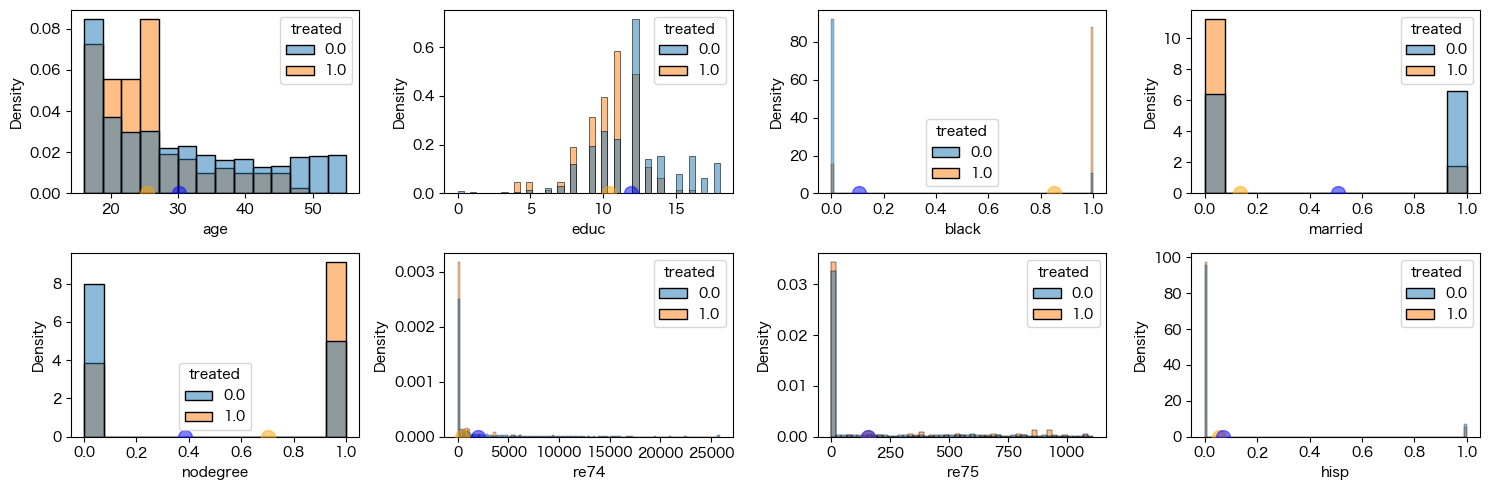

In [414]:
plot_distribution(df_obs_seg[df_obs_seg[seg_col]=='<50'], X_cols, t_col)

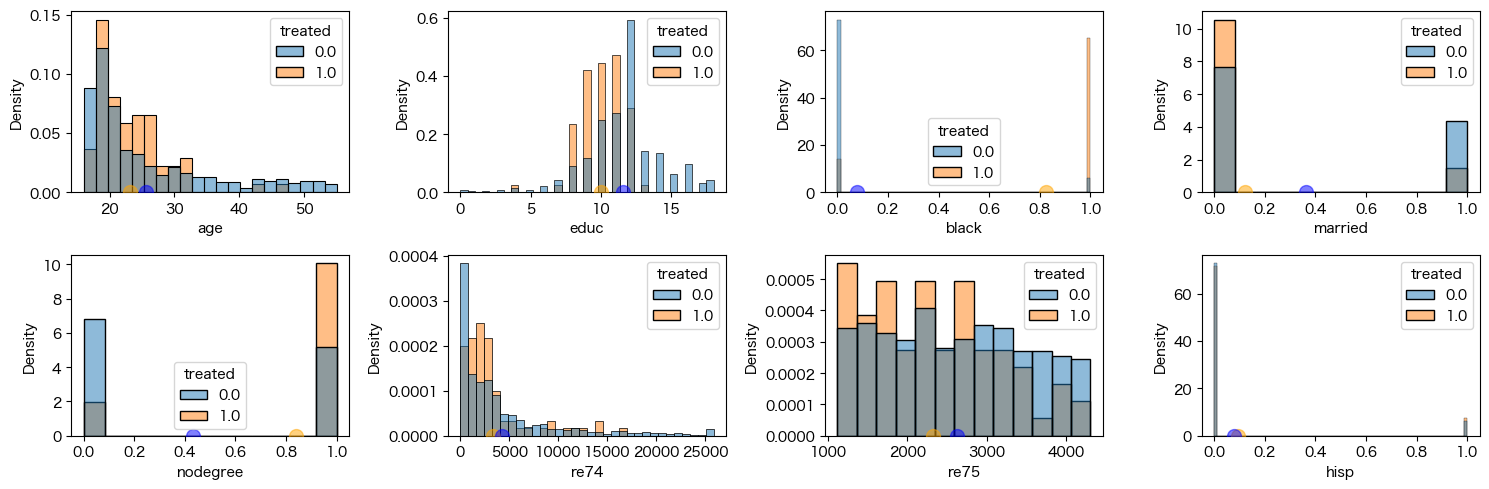

In [415]:
plot_distribution(df_obs_seg[df_obs_seg[seg_col]=='50<=x<75'], X_cols, t_col)

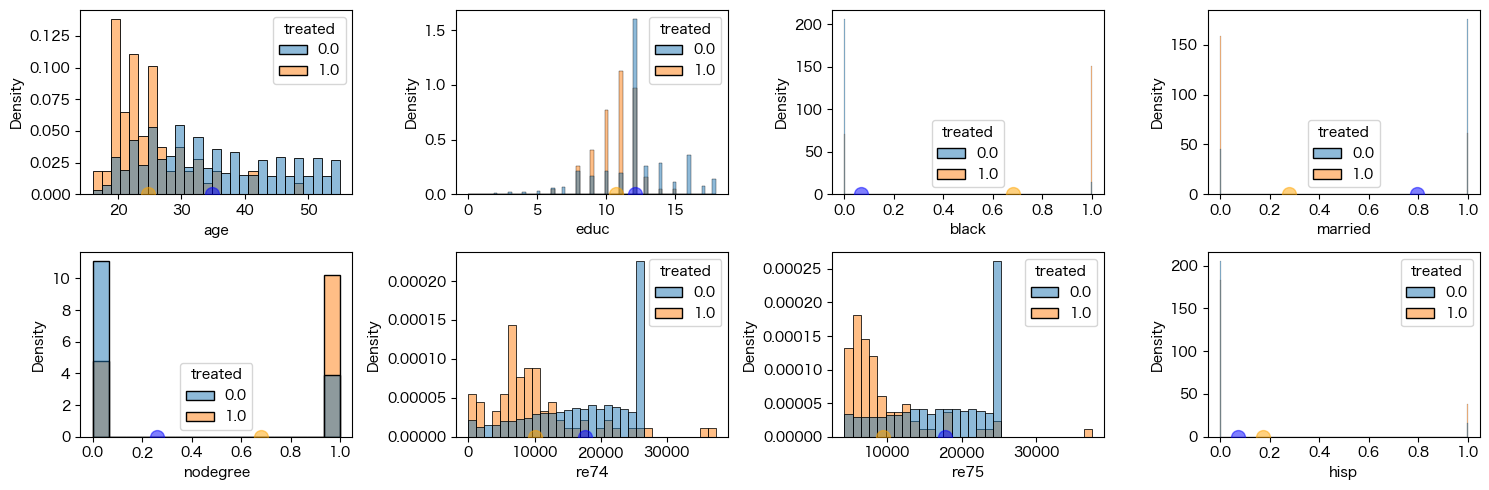

In [418]:
plot_distribution(df_obs_seg[df_obs_seg[seg_col]=='75<='], X_cols, t_col)

In [469]:
df_result = pd.DataFrame(columns=['segment', 'effect_obs', 'effect_exp', 'att_obs', 'att_exp'])
for seg in df_obs_seg[seg_col].unique():
    df_seg = df_obs_seg[df_obs_seg[seg_col]==seg]
    tweedie_results_seg = fit_tweedie_glm(df_seg, y_col, X_cols, t_col)
    effect_obs_seg = np.exp(tweedie_results_seg.params[t_col])
    att_obs_seg = (1 - 1 / effect_obs_seg) * df_seg.loc[df_seg['treated'] == 1, y_col].mean()
    
    df_seg = df_exp_seg[df_exp_seg[seg_col]==seg]
    tweedie_results_seg = fit_tweedie_glm(df_seg, y_col, X_cols, t_col)
    effect_exp_seg = np.exp(tweedie_results_seg.params[t_col])
    att_exp_seg = (1 - 1 / effect_exp_seg) * df_seg.loc[df_seg['treated'] == 1, y_col].mean()

    df_result = pd.concat([df_result, pd.DataFrame({
        'segment': [seg],
        'effect_obs': [effect_obs_seg],
        'effect_exp': [effect_exp_seg],
        # 'att_obs': [att_obs_seg],
        # 'att_exp': [att_exp_seg]
    })], ignore_index=True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   re78   No. Observations:                 2626
Model:                            GLM   Df Residuals:                     2616
Model Family:                 Tweedie   Df Model:                            9
Link Function:                    Log   Scale:                          9659.0
Method:                          IRLS   Log-Likelihood:                -1030.7
Date:                Tue, 30 Dec 2025   Deviance:                   1.9895e+07
Time:                        02:07:22   Pearson chi2:                 2.53e+07
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1428
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5955      0.234     36.659      0.0

In [470]:
df_result

,segment,effect_obs,effect_exp,att_obs,att_exp
0,<50,1.570329,1.336608,NaN,NaN
1,75<=,0.526321,0.950708,NaN,NaN
2,50<=x<75,0.846422,1.107466,NaN,NaN
